## Chargement des données
Afin de pouvoir traiter et manipuler nos données, nous avons associé les étiquettes aux avis correspondants, cela permet d'avoir une vision global de nos données

In [30]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
df1 = pd.read_csv("dataset.csv", sep="\t", header= None, encoding= "utf8")
df2 =  pd.read_csv("labels.csv", sep="\t", header= None, encoding= "utf8")
df = pd.concat([df1, df2], axis=1)#join='inner'
df.columns =["Avis", "Labels"]
display(df.head())

Avis  Labels
0  Obviously made to show famous 1950s stripper M...      -1
1  This film was more effective in persuading me ...      -1
2  Unless you are already familiar with the pop s...      -1
3  From around the time Europe began fighting Wor...      -1
4  Im not surprised that even cowgirls get the bl...      -1

# Word-cloud et Histogramme de notre jeu d'entrainement
Nous avions régarder les statistiques de notre jeu d'entrainenement : la fréquence d’un mot est signifiée par sa taille et sa couleur dans le Word Cloud(nuage de mots) et par des bares dans le cas de l'histogramme.
Cela nous permet d'avoir une idée des mots les plus utilisés dans notre jeu d'entrainenement.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
%matplotlib inline
stop = set(stopwords.words('english'))
stop.update(['.', ',', '"', "'", '?', '!', 'i',':', ';', '(', ')','-', '[', ']', '{', '}', '#' , 'http', 'https', '/', '\\','://', '_', 'co'])


In [3]:
corpus1= df['Avis']
corpus_str = corpus1.str.cat(sep = ' ')
list_mot = [i.lower() for i in wordpunct_tokenize(corpus_str) if i.lower() not in stop and i.isalpha()]
freq_mot = nltk.FreqDist(list_mot)
mot_frequents = freq_mot.most_common(25)
print(mot_frequents)

[('movie', 18323), ('film', 15236), ('one', 10598), ('like', 7926), ('good', 5463), ('even', 5338), ('time', 5160), ('would', 4995), ('see', 4827), ('really', 4461), ('story', 4448), ('bad', 3985), ('people', 3916), ('well', 3890), ('get', 3639), ('first', 3521), ('great', 3458), ('much', 3454), ('made', 3359), ('also', 3313), ('movies', 3262), ('make', 3229), ('could', 3179), ('way', 3030), ('watch', 2973)]


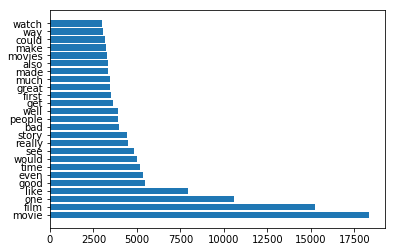

In [4]:
plt.barh(range(len(mot_frequents)),[val[1] for val in mot_frequents], align='center')
plt.yticks(range(len(mot_frequents)), [val[0] for val in mot_frequents])
plt.show()

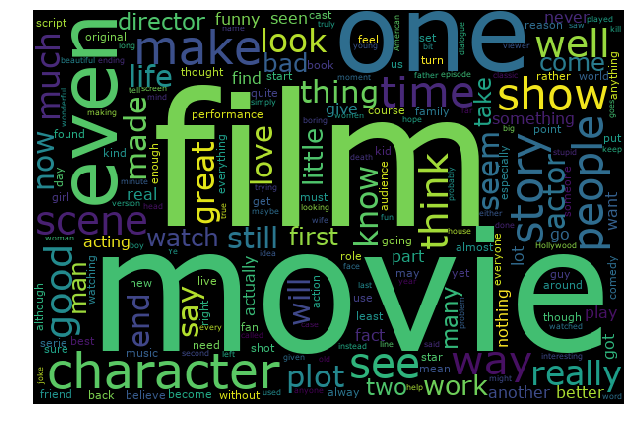

In [5]:
avis=''
for string in df['Avis']:
    if(string not in stop):
        avis=avis+string+' '
wordc = wc(width=600, height=400,font_path='/Library/Fonts/Verdana.ttf',).generate(avis)
plt.figure( figsize=(9,9))
plt.imshow(wordc)
plt.axis("off")
plt.tight_layout()
plt.show()

 On peut avoir plus de precisions en regardant les stats en fonctions des labels negatifs/ positifs

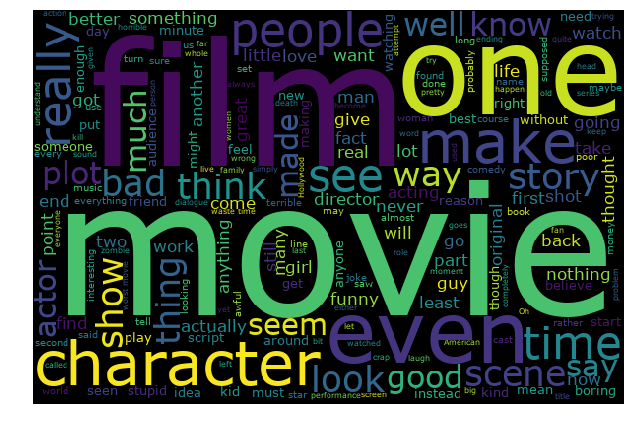

In [6]:
avis_neg=''
for string in df.iloc[:5000,0].values:
    if(string not in stop):
        avis_neg=avis_neg+string+' '
wordc = wc(width=600, height=400,font_path='/Library/Fonts/Verdana.ttf',).generate(avis_neg)
plt.figure( figsize=(9,9))
plt.imshow(wordc)
plt.axis("off")
plt.tight_layout()
plt.show()

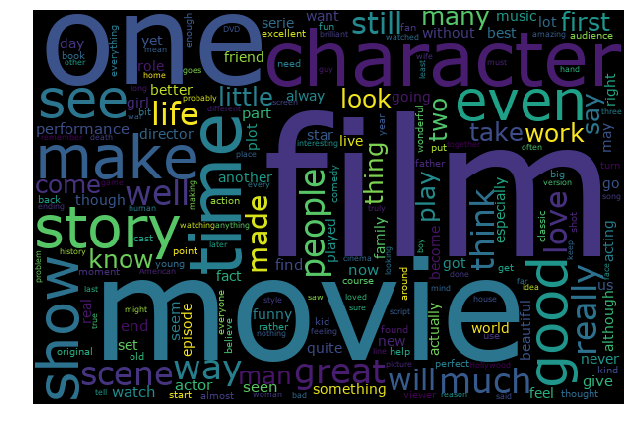

In [7]:
avis_pos =''
for string in df.iloc[5000:,0].values:
    if(string not in stop):
        avis_pos =avis_pos +string+' '
wordc = wc(width=600, height=400,font_path='/Library/Fonts/Verdana.ttf',).generate(avis_pos )
plt.figure( figsize=(9,9))
plt.imshow(wordc)
plt.axis("off")
plt.tight_layout()
plt.show()

## DEFINITIONS DU CORPUS ET DES LABELS

In [8]:
corpus = df.iloc[4000:6000,0].values
labels = df.iloc[4000:6000,1].values

## Pre-traitements et Constitution du sac de mots
Nous avons mis en place plusieurs pré-traitement afin d'avoir une meilleure accuracy lors des étapes de classifications

In [9]:
from nltk.tokenize import word_tokenize
import contractions
import nltk
import unicodedata
import re
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wordnet_lemmatizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


#Lematization
def lematization(word):
    tokens = word_tokenize(word)
    wordnet_lemmatizer = WordNetLemmatizer()
    lstemmed = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in tokens]
    return lstemmed

#on garde les contractions pour conserver la négation dans une phrases
def replace_contractions(text):
    return contractions.fix(text)

#on pourrait avoir des carctères non ascii, incomprehensible lors du traitement
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words



#mise en minuscule sachant que la transformation en sac de mot le fait, mais ici on veut tester avant d'appliquer le tfid
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word) 
    return new_words

#enleève les ponctuations, allège notre corpus
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stop:
            new_words.append(word)
    return new_words



#customize lematisation : livre bible datamining
def get_pos(words):
    words = nltk.word_tokenize(words)
    pos_string = nltk.pos_tag(words)
    corpus_tag = []
    for (word, tag) in pos_string:
        if tag in('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS','VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'):
            corpus_tag.append((word))
    #corpus_tag = "".join([" "+i for i in corpus_tag]).strip()
    return corpus_tag

#Regroupement des fonctions
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

##Regroupement des fonctions mais après tokenize
def clean_text(text): 
    text  = replace_contractions(text)
    tokens = word_tokenize(text)
    tokens=normalize(tokens)
    tokens = get_pos(text)
    text="".join([" "+i for i in tokens]).strip()
    return text

In [10]:
print( "Avant néttoyage pour un avis donné: \n", corpus[5])

Avant néttoyage pour un avis donné: 
 I knew this film was supposed to be so bad it was funny, so I went into it with that expectation. I just found it to be so bad it was murderously boring. The whiny theme song is funny for about 10 seconds, until you realize there is nothing clever about it except its intentionally irritating quality. Seeing things get splattered with tomatoes gets old in about 30 seconds. There is just nothing clever or funny about the film except for the premise. It could sustain a 3-4 minute comedy sketch maybe, but this is just not a feature film by any stretch of the imagination.


# Application des pré-traitements sur le corpus

## Néttoyage

In [11]:
wordCount =0
for i in range(len(corpus)):
    corpus[i] = clean_text(corpus[i])
    wordCount +=1
    corpus[i]= "".join([""+words for words in corpus[i]]).strip()
print("Après le premier néttoyage, pour l'intervalle choisie, le nombre de mots restant", wordCount)

Après le premier néttoyage, pour l'intervalle choisie, le nombre de mots restant 2000


In [12]:
print( "Après le premier néttoyage pour un avis donné: \n", corpus[5])

Après le premier néttoyage pour un avis donné: 
 knew was supposed be so bad was funny went just found be so bad was murderously boring whiny is funny realize is intentionally irritating Seeing get splattered gets old about is just funny sustain 3-4 maybe is just not


## Lematization

In [13]:
wordCount = 0 
for i in range(len(corpus)):
    corpus[i] = lematization(corpus[i])
    wordCount +=1
    corpus[i]= "".join([" "+words for words in corpus[i]]).strip()
print("Après la lemmatization, le nombre de mots restant", wordCount)

Après la lemmatization, le nombre de mots restant 2000


In [14]:
print( "Après la lematization pour un avis donné: \n", corpus[5])

Après la lematization pour un avis donné: 
 know be suppose be so bad be funny go just find be so bad be murderously bore whiny be funny realize be intentionally irritate Seeing get splatter get old about be just funny sustain 3-4 maybe be just not


## Constitution du sac des mots
Ici on donne un poids élevé aux mots qui apparaissent le plus souvent dans un document particulier mais pas dans de nombreuses documents du corpus : Si un mot apparait souvent dans un certain document, donc s'il y'a une fréquence élévée mais très rarement ailleurs, il est probabalement très réprésenantif du contenu de ce document.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( ngram_range=(1,3),min_df=5)#, preprocessor=clean_text, tokenizer=lematization)
vectors = vectorizer.fit_transform(corpus)

# contient le vocabulaire
df = pd.DataFrame(
    data=vectorizer.transform(corpus).toarray(),
    columns=vectorizer.get_feature_names()
)
df.head()

10  13th  20th  21st  abandon      able  able go  abound  about  about as  \
0  0.0   0.0   0.0   0.0      0.0  0.000000      0.0     0.0    0.0       0.0   
1  0.0   0.0   0.0   0.0      0.0  0.043521      0.0     0.0    0.0       0.0   
2  0.0   0.0   0.0   0.0      0.0  0.000000      0.0     0.0    0.0       0.0   
3  0.0   0.0   0.0   0.0      0.0  0.000000      0.0     0.0    0.0       0.0   
4  0.0   0.0   0.0   0.0      0.0  0.000000      0.0     0.0    0.0       0.0   

   ...  young be have  young have  young name  young not  young old  \
0  ...            0.0     0.00000         0.0        0.0        0.0   
1  ...            0.0     0.06574         0.0        0.0        0.0   
2  ...            0.0     0.00000         0.0        0.0        0.0   
3  ...            0.0     0.00000         0.0        0.0        0.0   
4  ...            0.0     0.00000         0.0        0.0        0.0   

   young play  younger  younger be  youngest  your  
0         0.0      0.0         0.0       0.0   0.0  
1         0.0      0.0         0.0       0.0   0.0  
2         0.0      0.0         0.0       0.0   0.0  
3         0.0      0.0         0.0       0.0   0.0  
4         0.0      0.0         0.0       0.0   0.0  

[5 rows x 6537 columns]

In [16]:
feature = vectorizer.get_feature_names()
feat =''
for string in feature:
    feat =feat +string+' '
wordc = wc(width=600, height=400,font_path='/Library/Fonts/Verdana.ttf',).generate(feat)
plt.figure( figsize=(9,9))
plt.imshow(wordc)
plt.axis("off")
plt.tight_layout()
plt.show()

## Entrainement des classifieurs

In [17]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline




from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier



from time import time
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

In [18]:
X = vectors.toarray()
y = labels

## Plusieurs classifieurs 
Afin de faire le choix du classifieur adapté pour nos données, nous avons fait les prétraitements avec plusieurs classifieurs. Nous avons non seulement varierles paramètres du tfidVectorizer mais aussi nous avons choisi d'appliquer la lemmatisation (nous nous sommes contenter de mettre les verbes à l'infinif car enlever les pluriels n'est pas un choix judicieux) ou non. 
\\
Ensuite nous analysons le resultat pour choisir le meilleur classifieur en fonction du prétraitement, la déviation standard et les  boites à moustache nous ont permis de faire le bon choix

In [19]:
seed = 7  #germe
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression())) #parametre nom et fonction de la classif
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel = "linear")))
models.append(('SGD',SGDClassifier()))
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed) #separation cross-validation
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring) #appel fontion cross val
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.796500 (0.028289)
KNN: 0.665500 (0.103862)
CART: 0.672500 (0.029090)
NB: 0.672000 (0.057758)
SVM: 0.843000 (0.031241)
SGD: 0.836500 (0.121038)


## Comparaison des algorithmes de classifications
Il apparait que SVM est le meilleur parmi les autres classifieurs, nous le confirmons avec une boite à moustache pour comparer les differents classifieurs.

[Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'SVM'),
 Text(0, 0, 'SGD')]

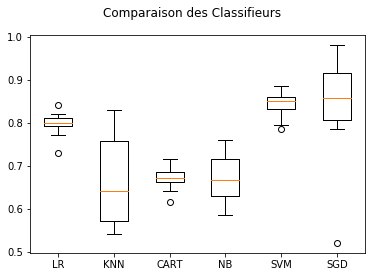

In [20]:
import seaborn as sns
fig = plt.figure()
fig.suptitle("Comparaison des Classifieurs")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Utilisation de SVM
Nous avons choisi SVM à l'issue de la comparaison avec les autres classiffieurs, analysons de plus prêt ce dernier

In [21]:
validation_size=0.3 #30% du jeu de données pour le test

testsize= 1-validation_size
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)
clf = SVC(kernel = 'linear')
clf.fit(X_train, y_train)
result = clf.predict(X_test)

print('\n accuracy:',accuracy_score(result, y_test),'\n')


 accuracy: 0.8428571428571429 



# Evaluation du modèle avec les 2000 données d'entrainement

In [22]:

conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)
print ('\n',classification_report(y_test, result))


 matrice de confusion 
 [[583 111]
 [109 597]]

               precision    recall  f1-score   support

          -1       0.84      0.84      0.84       694
           1       0.84      0.85      0.84       706

   micro avg       0.84      0.84      0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400



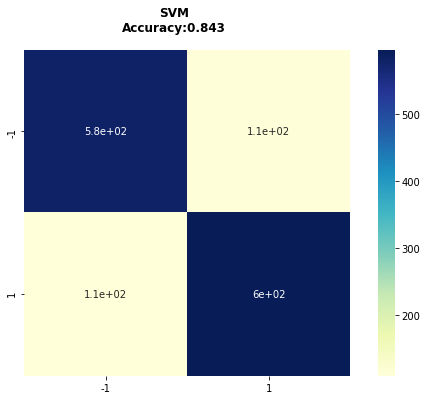

In [23]:
labels = ['-1', '1']
fig, ax = plt.subplots(1, 1, figsize=(10,6))
hm = sns.heatmap(conf, 
                 ax=ax,           # Axes où afficher
                 xticklabels=labels, #labels sur les x
                 yticklabels=labels, #labels sur les colonnes
                 cmap="YlGnBu", # Couleur
                 square=True,    # Si True, toutes les cellules 
                                 #ont le même aspect carré
                 annot=True      # Pour afficher les valeurs
                )
fig.suptitle('SVM\nAccuracy:{0:.3f}'.format(accuracy_score(result,y_test)), 
              fontsize=12, 
              fontweight='bold')
plt.show()

## Recherche des meilleurs paramètres pour le modèle

In [24]:
grid_param = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'gamma' : [0.001, 0.01, 0.1, 1], 
    'kernel': ['linear','rbf']}

gd_sr = GridSearchCV(estimator=SVC(),  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1,
                     iid=True,
                    return_train_score=True)

gd_sr.fit(X_train, y_train)  

print ('meilleur score ',gd_sr.best_score_,'\n')
print ('meilleurs paramètres', gd_sr.best_params_,'\n')
print ('meilleur estimateur',gd_sr.best_estimator_,'\n')


meilleur score  0.8483333333333334 

meilleurs paramètres {'C': 10, 'gamma': 1, 'kernel': 'rbf'} 

meilleur estimateur SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 



## Utilisation des meilleurs paramètres avec le k-Fold on évite de créer un biais lors de l'apprentissage

In [25]:
seed=7
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
clf = SVC(C= 10, gamma = 1, kernel = 'rbf')
scoring = 'accuracy'
t0 = time()
score = cross_val_score(clf, X, y, cv=k_fold, scoring=scoring)
print("Réalisé en %0.3fs" % (time() - t0))

print('Les différentes accuracy pour les 10 évaluations sont : \n',
      score,'\n')
print ('Accuracy moyenne : ',score.mean(), 
       ' standard deviation', score.std())

Réalisé en 290.154s
Les différentes accuracy pour les 10 évaluations sont : 
 [0.89  0.895 0.87  0.865 0.905 0.9   0.875 0.89  0.885 0.845] 

Accuracy moyenne :  0.882  standard deviation 0.01734935157289749


## Mise en place d'une pipeline sur tout le jeu d'entrainement afin de sauvegarder le modèle appris et les pré-traitements

In [31]:
##RELECTURE
dfp1 = pd.read_csv("dataset.csv", sep="\t", header= None, encoding= "utf8")
dfp2 =  pd.read_csv("labels.csv", sep="\t", header= None, encoding= "utf8")
dfp = pd.concat([dfp1, dfp2], axis=1)#join='inner'
dfp.columns =["Avis", "Labels"]

In [32]:
corpus = df.iloc[:,0].values
labels = df.iloc[:,1].values
array = dfp.values
X = corpus
y = labels

X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)

Lancement du fit 

Fit réalisé en 44.030s
Lancement de la prédiction 

Prédiction réalisée en 101.444s

 accuracy: 0.8827142857142857 


 matrice de confusion 
 [[3053  430]
 [ 391 3126]]

               precision    recall  f1-score   support

          -1       0.89      0.88      0.88      3483
           1       0.88      0.89      0.88      3517

   micro avg       0.88      0.88      0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000



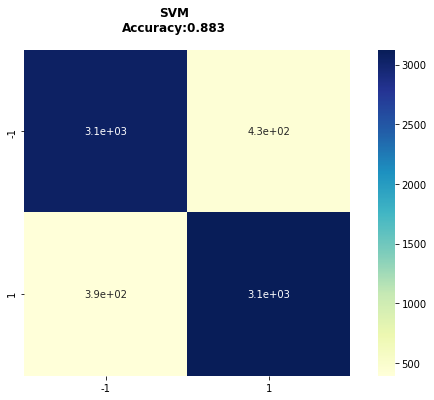


Sauvegarde du pipeline grid search


In [33]:
vec =TfidfVectorizer(preprocessor=clean_text, min_df=5, ngram_range=(1,3), tokenizer= lematization)

pipeline = Pipeline([('vect', vec),
                ('clf', SVC(C=10, gamma =1, kernel ='rbf')),])


t0 = time()
print ("Lancement du fit \n")
pipeline.fit(X_train, y_train)
print("Fit réalisé en %0.3fs" % (time() - t0))

t0 = time()
print ("Lancement de la prédiction \n")
result = pipeline.predict(X_test)
print("Prédiction réalisée en %0.3fs" % (time() - t0))

print('\n accuracy:',accuracy_score(result, y_test),'\n')

conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)



print ('\n',classification_report(y_test, result))



labels = ['-1', '1']
fig, ax = plt.subplots(1, 1, figsize=(10,6))
hm = sns.heatmap(conf, 
                 ax=ax,           # Axes où afficher
                 xticklabels=labels, #labels sur les x
                 yticklabels=labels, #labels sur les colonnes
                 cmap="YlGnBu", # Couleur
                 square=True,    # Si True, toutes les cellules 
                                 #ont le même aspect carré
                 annot=True      # Pour afficher les valeurs
                )
fig.suptitle('SVM\nAccuracy:{0:.3f}'.format(accuracy_score(result,y_test)), 
              fontsize=12, 
              fontweight='bold')
plt.show()

print("\nSauvegarde du pipeline grid search") 
filename = 'SVC_MODEL.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

## Essai sur le Jeu de données de challenge

In [34]:
df_test = pd.read_csv("cha_data.csv", sep="\t", header= None, encoding= "utf8")
y_test =  pd.read_csv("cha_labels.csv", sep="\t", header= None, encoding= "utf8")
dftest = pd.concat([df_test, y_test], axis=1)#join='inner'
dftest.columns =["Avis", "Labels"]
corpus2 = dftest.iloc[:,0]
labels2 =  dftest.iloc[:,1]

In [35]:

print ("Chargement du modèle \n")
filename = 'SVC_D.pkl'
clf_loaded = pickle.load(open(filename, 'rb'))


print ("Prédiction données chalenge (*-*)\n")

result = clf_loaded.predict(corpus2)

print('\n accuracy:\n')
print (accuracy_score(result, y_test),'\n')

Chargement du modèle 

Prédiction données chalenge (*-*)


 accuracy:

0.885 



## Matrice de confusion


 matrice de confusion 
 [[1762  238]
 [ 222 1778]]

               precision    recall  f1-score   support

          -1       0.89      0.88      0.88      2000
           1       0.88      0.89      0.89      2000

   micro avg       0.89      0.89      0.89      4000
   macro avg       0.89      0.89      0.88      4000
weighted avg       0.89      0.89      0.88      4000



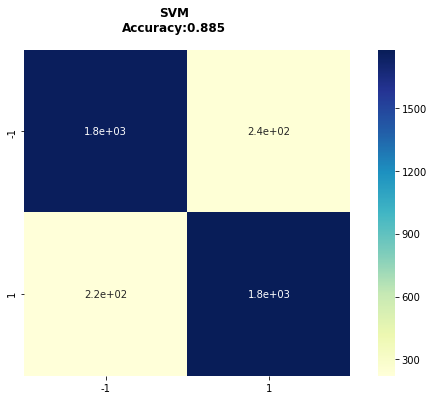

In [36]:
conf = confusion_matrix(y_test, result)
print ('\n matrice de confusion \n',conf)



print ('\n',classification_report(y_test, result))



labels = ['-1', '1']
fig, ax = plt.subplots(1, 1, figsize=(10,6))
hm = sns.heatmap(conf, 
                 ax=ax,           # Axes où afficher
                 xticklabels=labels, #labels sur les x
                 yticklabels=labels, #labels sur les colonnes
                 cmap="YlGnBu", # Couleur
                 square=True,    # Si True, toutes les cellules 
                                 #ont le même aspect carré
                 annot=True      # Pour afficher les valeurs
                )
fig.suptitle('SVM\nAccuracy:{0:.3f}'.format(accuracy_score(result,y_test)), 
              fontsize=12, 
              fontweight='bold')
plt.show()